# Extended data supporting the study of rundown modelling of L-type calcium current

This notebook provides supporting material that supplements the understanding of the methods undertaken and the results obtained in this study in Sections A and B.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import myokit
from IPython.display import Image
import os
import json
import scipy

import sys
sys.path.append('supporting')

import parameters
import helpers

### A. Supporting material for methods

Here we show how the experimental range for the channel density and radius was determined (A.1), show the analytical solution for diffusion of pure buffer inside a cell for our geography of interest (A.2), convergence test for the disretisation scheme adopted in the study (A.3), how KIC50 is embedded in the numerical scheme (A.4), using calcium transients as a proxy for ICaL to study rundown (A.5), and how the blocking of $f_{Ca}$ does affect the results of this study.


##### A.1 Experimental range of the L-type calcium channel (LCC) density and radius

###### A.1.1 L-type calcium channel (LCC) density 

We use the peak-ICaL recorded from previous experiments to estimate the range of the channel density ($P_{Ca}$).
From the previous study, we know that the peak-ICaL varies from -490.70 pA to -4444.386 pA.
A scatter plot of the same is shown below.

Max ICaL -490.7041936534882
Min ICaL -4444.386426318047


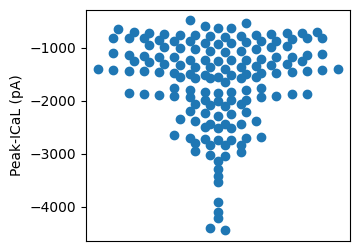

In [2]:
ical_peak = pd.read_csv('resources/all_peak_ical.csv').to_numpy().tolist()
ical_peak = [x[0] for x in ical_peak] # data in list format
print('Max ICaL', max(ical_peak))
print('Min ICaL', min(ical_peak))

x_swarm = helpers.simple_beeswarm(ical_peak)

plt.figure(figsize=(3.4, 3))
plt.scatter(x_swarm, ical_peak)
plt.ylabel('Peak-ICaL (pA)')
plt.xticks([])
plt.show()
plt.close()


We then simulate the model used in this study to determine the value of the entity given by $\delta * O$ at the step voltage-clamp protocol used for the experiment described in the main article.

Peak open probability: -97458.13110947041


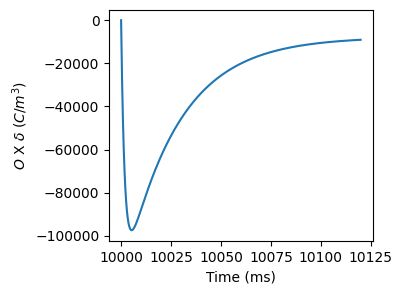

In [3]:
mod_path = 'resources/zeng-ical-template.mmt'
mod = myokit.load_model(mod_path)
pca = mod.get('L_type_Ca_current.P_Ca').pyfunc()()
mod.get('L_type_Ca_current.open_prob').set_rhs('d*f')
mod.get('calcium_dynamics.diffusion').set_rhs(0)
mod.get('calcium_dynamics.buffering').set_rhs(0)
mod.get('calcium_dynamics.current').set_rhs(0)
mod.get('membrane.V').set_binding(None)

s = myokit.Simulation(mod)
s.set_tolerance(abs_tol=1e-9, rel_tol=1e-09)
s.set_constant('membrane.V', -90)
s.run(10000, log=[]) # 10 seconds
s.set_constant('membrane.V', 0.001)
t = s.time()
times = np.arange(t, t+120, 0.1)
d = s.run(120, log=['L_type_Ca_current.i_CaL'], log_times = times)

op = np.divide(d['L_type_Ca_current.i_CaL'], pca)
#print('max op', max(op))
print('Peak open probability:', min(op))

plt.figure(figsize=(3.4, 3))
plt.plot(times, op)
plt.ylabel('$O$ X $\delta$ ($C/m^3$)')
plt.xlabel('Time (ms)')
plt.show()
plt.close()

By dividing the peak observed ICaL range with the peak open probability, we estimate that $P_{Ca}$ varies from 0.005 nL/s to 0.0457 nL/s.

###### A.1.2 Cell's radius

We similarly use the experimental recordings of the previous patch-clamp experiment to estimate the range of the cell's radius.
We used two methods for this purpose, first was to use the microscopic recordings and the second was the capacitance recordings.

In the first method, we used the radius of the cell measured under a microscope before the patch-clamp experiment was conducted.
Within this, the measurement could have corresponded to a hemispherical or a spherical cell.
Assuming that the volume of the cell remained conserved, the volume of the cell before and after can be equated in both cases to determine the new range of the cell's radius.

In an alternative method, $R_0$ was estimated using the $C_m$ measured from the Syncropatch, by assuming that the specific capacitance of all cells was 1 microF/${cm}^{2}$.
Now, there are further two kinds of variations here: one where the surface area only consists of the curved portion of the hemisphere and the other where both the curved hemisphere and flat surface pressed against the chip plate contribute to the surface area.  

The cell-range using each method is shown below and we take the exhaustive range estimated by all methods.

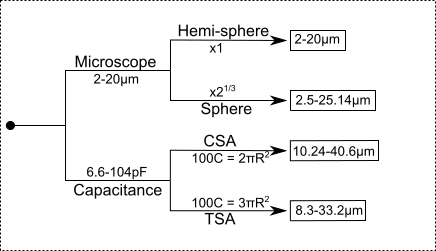

In [4]:
image_path = "supporting/flowchart_R.png"
Image(filename=image_path)

##### A.2 Diffusion of pure buffer inside a cell

An analytical solution was previously derived ([doi: 10.22489/CinC.2022.051](doi:10.22489/CinC.2022.051)) for the diffusion of pure buffer inside the cell for the geography of interest used in the main article.
The solution showed that the buffer concentration with space and time can be represented by a relationship of the dimensionless quantitites given by $u(x, \tau)$, $x$, and $\tau$.

The dimensionless quantities are given by: $u(x, \tau) = \frac{Br}{B_{max}R_h}$, $x = \frac{r - R_0}{R_h - R_0}$, and $\tau = \frac{D_Bt}{(R_h - R_0)^2}$.

The solution is given by

\begin{equation*}
    u(x, \tau) = \frac{hx - 1}{h-1} - \sum_{n=1}^{\infty}\frac{\alpha_n}{\beta_n} [\sin{\lambda_nx} -\frac{\lambda_n}{h}\cos{\lambda_nx}]\exp({-\lambda_n^2\tau}),
\end{equation*}
where,
\begin{equation*}
    \alpha_n = \frac{1}{h-1}\left[ \left (\frac{1}{h} + \frac{h}{\lambda_n^2} -1\right)\sin{\lambda_n} - \frac{h}{\lambda_n}\cos{\lambda_n}\right],
\end{equation*}

\begin{equation*}
    \beta_n = \frac{1}{2h^2}\left[\lambda_n^2 + h^2 + \frac{\lambda_n^2-h^2}{2\lambda_n}\sin{2\lambda_n} - 2h\sin^2{\lambda_n} \right],
\end{equation*}

and the roots of the solution ($\lambda_n$) are given by the positive roots of:

\begin{equation*}
    \tan{\lambda_n} = \frac{\lambda_n}{h}.
\end{equation*}

The figure below shows the concentration profile of the buffer at different snapshopts of time for a cell with the maximum possible radius used in this study ($40.6$ microm).

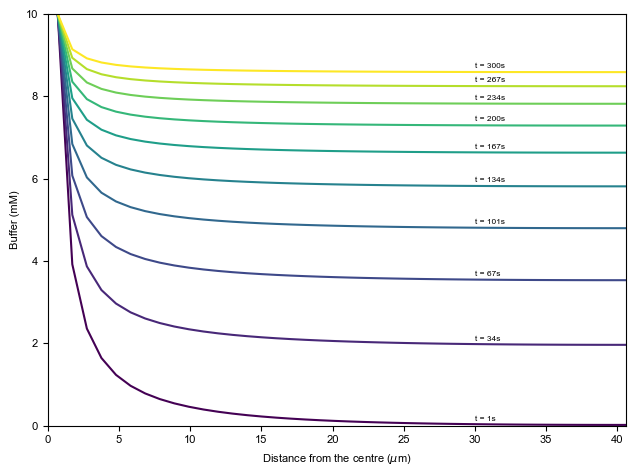

In [5]:
import analytical_solution
analytical_solution.plot_largest_r()

Next, we show the time taken for complete equilibration of the buffer for the range of the cell radius used in this study in the plot below.
We find that the relationship between size of the cell ($R_0$) and $t_{diff}$ is given by the equation below:

\begin{equation*}
t_{diff} = 0.011R_0^3 - 0.02R_0^2 + 0.117R_0 - 0.402.
\end{equation*}

Therefore, $t_{diff}$ varies from 0.04s to 708.19s for cells with $R_0$ varying from 2 microm to 40.6 microm.

R min (um) 2.0 tdiff (s) 0.04178888351078574
R max (um) 40.6 tdiff (s) 708.1918628024928


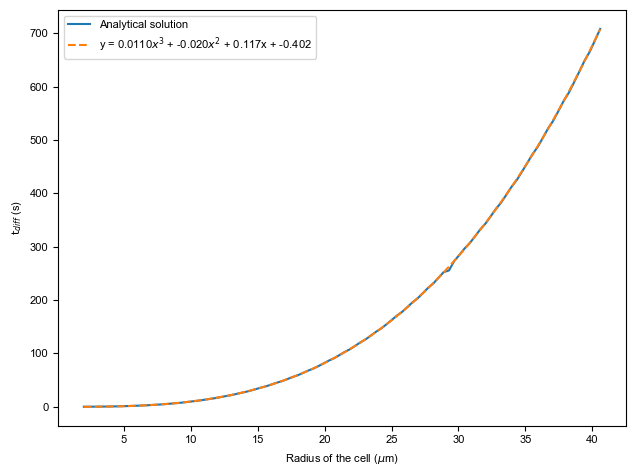

In [6]:
analytical_solution.plot_tau_max()

##### A.3 Convergence test
Next we use the analytical solutions to perform a convergence test to determine the minimum number of shells that a cell should be discretised into so that the resulting simulation has a very low error when compared to the true solution. 

For this test, a cell of the maximum possible radius, 40.6 microm, and the maximum time of interest (300s) was used to determine the convergence conditions for the `most difficult configuration'.

The left panel in the figure below shows the concentration profile of the free buffer using the derived analytical solution shown above, and discretisation of the equations described in the main text for varying values of $N$. 
We can see that the discretised simulations closely resemble the `true' solution.

We then calcualate the error in prediction for the outermost point corresponding to different shell width ($R_0/N$) and plot it on the right.
We calculate the absolute difference of the predicted buffer and the true solution and normalise it with respect to the true buffer concentration calculated from the analytical solution. 
The right panel in the figure below shows the convergence of error at smaller $L$ (larger $N$).

Simulations at all $N$ shown in this figure show negligible error.
We chose a shell width of approximately 0.05 microm ((40.6-1 microm)/800) as the minimum shell width that all numerical discretisations should have.
This ensures that the error in the buffer at any point is less than 1.5% (ln(0.015)=-4.2).

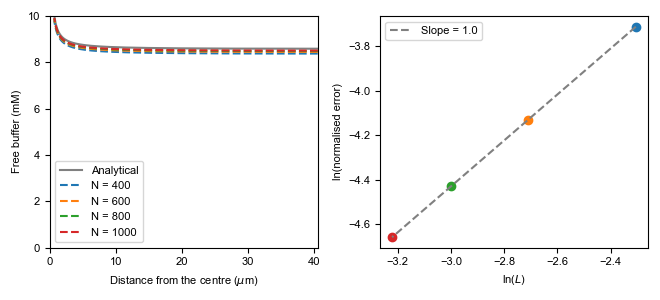

In [7]:
# run using convergence.py

image_path = "supporting/convergence.png"
Image(filename=image_path)

##### A.4 KIC50 is embedded in the numerical scheme
In the convergence test above, we showed that the concentration of the buffer near the LCCs (in the outermost shell) converges to the true solution for shell width of approximately 0.05 microm.

Though we have chosen the shell width to be small enough that the simulated buffer concentration resembles the true solution, the calcium concentration is directly influenced by the discretisation scheme because the ICaL that enters the cell goes into the discretised volume of the outermost shell.  
This calcium concentration then feeds into the calcium-dependent gate: $f_{Ca} = 1/(1+ [Ca^{2+}]/KIC50)$.

This implies that a change in the dicretisation scheme should be associated with a change in the KIC50 parameter to ensure that the simulated ICaL remains unchcnaged.

We show that KIC50 is embedded in the numerical scheme by simulating the model at $N=600$ for one sweep as shown below.

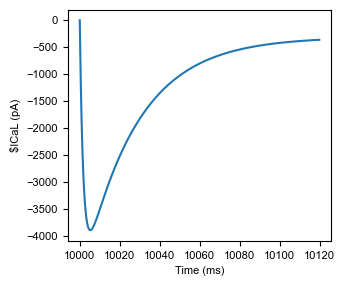

In [8]:
mod_path = 'resources/zeng-ical-template.mmt'
mod = myokit.load_model(mod_path)
pca = mod.get('L_type_Ca_current.P_Ca').pyfunc()()
mod.get('L_type_Ca_current.open_prob').set_rhs('d*f')
calcium_dynamics = mod.get('calcium_dynamics')
N = calcium_dynamics.get('N')
N.set_rhs(600)
mod.get('membrane.V').set_binding(None)

s = myokit.Simulation(mod)
s.set_tolerance(abs_tol=1e-9, rel_tol=1e-09)
s.set_constant('membrane.V', -90)
s.run(10000, log=[]) # 10 seconds
s.set_constant('membrane.V', 0.001)
t = s.time()
times = np.arange(t, t+120, 0.1)
d = s.run(120, log=['L_type_Ca_current.i_CaL'], log_times = times)

plt.figure(figsize=(3.4, 3))
plt.plot(times, d['L_type_Ca_current.i_CaL'])
plt.ylabel('$ICaL (pA)')
plt.xlabel('Time (ms)')
plt.show()
plt.close()

We then use this data to optimise models with different $N$ and determine the corresponding KIC50.
The relationship of the shell width and KIC50 determined is shown below.

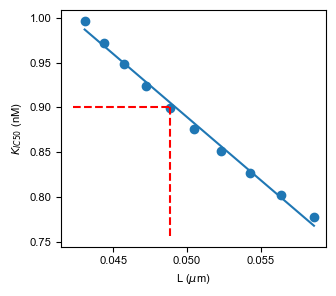

In [9]:
path = 'supporting/output/'
files = os.listdir(path)

ic50_para = []
N_range = []
for f in files:
    N_range.append(int(f[5:8]))
    jsonfile = open(path + f)
    data = json.load(jsonfile)
    jsonfile.close()

    score = pd.DataFrame(data['final error score'])
    ic50 = pd.DataFrame(data['final parameters'])
    score = score.sort_values(0)
    index = score.index
    ic50_acscending = []
    for i in range(len(index) -2):
        ic50_acscending.append(ic50.loc[index[i]].to_list()[0])
    ic50_acscending = pd.DataFrame(ic50_acscending)
    ic50_para.append(1e6*ic50_acscending.median(axis = 0).to_list()[0]) # convert to um


def fun(x, m, c):
    """
    Linear fit according to inital data
    """
    return m*x + c

R = 30 # um
N_range = np.array(N_range)
dR_range = np.array([(R -parameters.Rh*1e4)/x for x in N_range])
ic50_para = np.array(ic50_para)
popt, _ = scipy.optimize.curve_fit(fun, dR_range, ic50_para)
times = np.arange(10000, 10150, 0.1) # milli seconds

fig = plt.figure(figsize=(3.4, 3))
ic50n = fig.add_subplot(111)
ind = np.where(N_range == 600)[0][0]

for i in range(len(files)):
    ic50n.scatter(dR_range[i], ic50_para[i], color = '#1f77b4')
ic50n.plot(dR_range, fun(dR_range, *popt), color = '#1f77b4')

x_min, _, y_min, _ = plt.axis()
ic50n.hlines(0.9, x_min, (30-parameters.Rh*1e4)/600, color = 'red', ls = '--')
ic50n.vlines((30-parameters.Rh*1e4)/600, y_min, 0.9, color = 'red', ls = '--')
ic50n.set_xlabel('L ($\mu$m)')
ic50n.set_ylabel('$K_{IC50}$ (nM)')

plt.tight_layout()
plt.show()
plt.close()

The red dotted lines shows the corresponds to the shell width and KIC50 used to generate the model's simulation (N=500).
The figure shows that in order to replicate the same current, with a change in shell width, the corresponding KIC50 should change inversly.

##### A.5 Calcium transients used as a proxy to study rundown

To prevent the choice of numerical scheme from influencing the results of this study, the effect of $f_{Ca}$ was blocked completely, and instead trends of peak-calcium were used as a proxy for investigating rundown due to calcium-dependent inactivation (CDI).
This allows the impact of CDI to be studied separately from the source of $Ca^{2+}$ (ICaL).

In this study, we are interested in the qualitative trends of the decay in current, therefore we show how the rundown-versus-time patterns observed for ICaL (linear, saturating, and inverse), translate to corresponding calcium trends.

When comparing the peak-ICaL and peak-Ca at successive sweeps, the voltage-dependent kinetics remains the same, and only $f_{Ca}$ changes, therefore the relationship can be written using a positive constant $\alpha$ as:
\begin{equation}
    I = - \alpha \cdot f_{Ca},
\end{equation}

\begin{equation}
    I = - \alpha \cdot \frac{1}{1 + [{Ca}^{2+}]/K_{IC50}},
\end{equation}

where $I$ is the peak-ICaL during the activation step.
This equation can be re-written as:
\begin{equation}
    [{Ca}^{2+}] = -K_{IC50}\left(1 + \frac{1}{I_{\text{\textit{norm}}}}\right),
\end{equation}
where, $I_{\text{\textit{norm}}}$ is the normalised current ${I}/{\alpha}$.

This equation can now be used to determine the qualitative trend of peak-[Ca] corresponding to each pattern of rundown.
The top row of figure below shows different linear, saturating, and inverse functions which resemble the different patterns of rundown-versus-time plot.
These functions are taken as $I_{{{norm}}}$ and passed through the equation above to obtain the corresponding pattern of (peak-[Ca])-versus time curve.

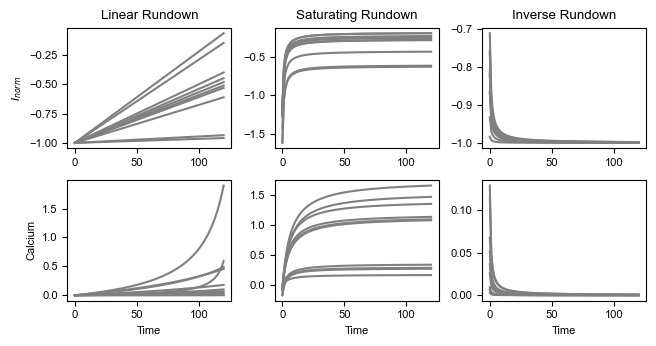

In [10]:
fig = plt.figure(figsize=(6.6, 3.5))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

ax1.set_ylabel('$I_{norm}$')
ax1.set_title('Linear Rundown')
ax4.set_ylabel('Calcium')
ax2.set_title('Saturating Rundown')
ax3.set_title('Inverse Rundown')
ax4.set_xlabel('Time')
ax5.set_xlabel('Time')
ax6.set_xlabel('Time')

t = np.linspace(0, 120, 100)
for _ in range(10):
    x = helpers.lin(t)
    ax1.plot(t, x, color = 'grey')
    ax4.plot(t, helpers.calcium(x), color = 'grey')
    x = helpers.logar(t)
    ax2.plot(t, x, color = 'grey')
    ax5.plot(t, helpers.calcium(x), color = 'grey')
    x = helpers.hyper(t)
    ax3.plot(t, x, color = 'grey')
    ax6.plot(t, helpers.calcium(x), color = 'grey')
    
plt.tight_layout()
plt.show()
plt.close()

This plot of shows that the rundown-versus-time patterns translate to (peak-calcium)-versus-time patterns as follows:
1) Linear rundown -> hyperbolic or linear shape of peak-[Ca]-versus time
2) Saturating rundown -> saturating shape of peak-[Ca]-versus time
3) Inverse rundown -> inverse shape shape of peak-[Ca]-versus time

Finally, it is self-explanatory that for no rundown, there would correspondingly be no change in peak-[Ca] across sweeps.

##### A.6 Blocking $f_{Ca}$ does not affet the qualitative trend of rundown

We recreated Figure 6 of the main article by blocking $f_{Ca}$.
The resultant submembrane calcium concentration is plotted below for both cases.
This plot confirms that blocking $f_{Ca}$ has no qualitative effet on the results of this study. 

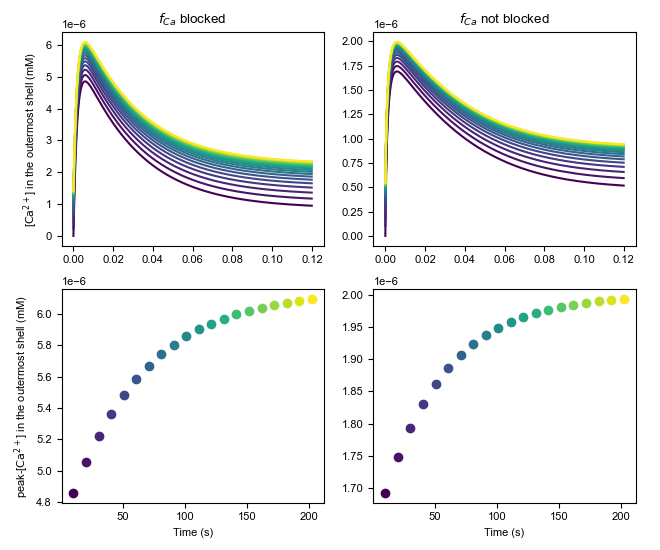

In [11]:
# supporting/figure_6_no_fca.py

image_path = "supporting/figure6_no_fca.png"
Image(filename=image_path)

### B. Supporting material for results

Here we show that $\zeta$ can be accurately used to predict the rundown trend (B.1), probability of observing one kind of rundown trend over the other (B.2), and recreate all results of the study to show that blocking of $f_{Ca}$ does not make any qualitaitve difference. 

##### B.1 $\zeta$ value and the corresponding rundown trend
For 1000 random draw of the three time constants - $t_0$, $t_{hold}$, and $t_{diff}$ in which $t_{hold}$ is the smalles of all time constants, we simulated the model to observe the rundown trend.
The $\zeta$ values and the rundown shapes are shown below.

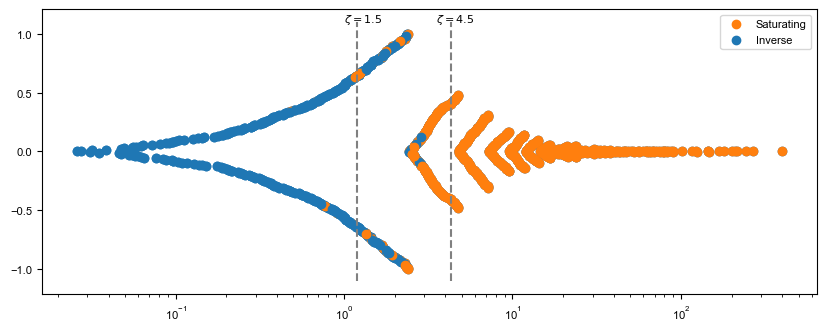

In [12]:
# zeta_accuracy.py

zeta_data = pd.read_csv('supporting/zeta_accuracy_thold.txt', sep = " | ", engine='python')
zeta = zeta_data['zeta']
trend = zeta_data['trend']
thold = zeta_data['thold']
tdiff = zeta_data['tdiff']
t0 = zeta_data['t0']

y_arr = helpers.simple_beeswarm(zeta.to_list())


plt.figure(figsize=(10, 3.7))
plt.scatter(zeta, y_arr)
for i in range(len(zeta)):
    ts = [thold[i], tdiff[i], t0[i]]
    if min(ts) == thold[i]:
        if trend[i] == 'saturating':
            plt.scatter(zeta[i], y_arr[i], color = 'tab:orange')
        else:
            plt.scatter(zeta[i], y_arr[i], color = 'tab:blue')

        
plt.vlines(1.2, ymin = -1.1, ymax = 1.1, ls = '--', color='grey')
plt.vlines(4.3, ymin = -1.1, ymax = 1.1, ls = '--', color='grey')
plt.scatter([], [], color = 'tab:orange', label = 'Saturating')
plt.scatter([], [], color = 'tab:blue', label = 'Inverse')
plt.text(1.0, 1.1, "$\zeta = 1.5$")
plt.text(3.5, 1.1, "$\zeta = 4.5$")

plt.xscale('log')
plt.legend(loc='best')
plt.show()
plt.close()


This plot shows that for most saturating scenarios, $\zeta$ is greater than 4.5, and for most inverse scenarios, $\zeta$ is less than 1.5.
The accuracy of $\zeta$ is given below.

In [13]:
thold_accuracy = []
for i in range(len(zeta)):
    ts = [thold[i], tdiff[i], t0[i]] 
    if min(ts) == thold[i]:
        if trend[i] == 'saturating':
            if zeta[i] > 4.5:
                thold_accuracy.append(1)
            elif zeta[i] < 1.5:
                thold_accuracy.append(0)
        else:
            if zeta[i] > 4.5:
                thold_accuracy.append(0)
            elif zeta[i] < 1.5:
                thold_accuracy.append(1)
    else:
        continue

perc = 100*sum(thold_accuracy)/len(thold_accuracy)
print('Accuracy of zeta prediction is:', perc, '%')
print('Number of samples is:', len(thold_accuracy) )

Accuracy of zeta prediction is: 97.73030707610147 %
Number of samples is: 749


We repeat the study above where $t_{diff}$ is the minimum instead of $t_{hold}$

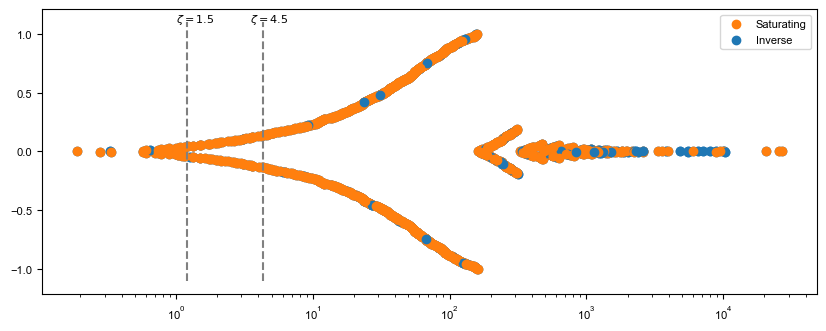

In [14]:
# Results of the case when tdiff is the smallest here
zeta_data_arr = pd.read_csv('supporting/zeta_accuracy_tdiff.txt', sep = " | ", engine='python')
zeta_arr = zeta_data_arr['zeta']
trend_arr = zeta_data_arr['trend']
thold_arr = zeta_data_arr['thold']
tdiff_arr = zeta_data_arr['tdiff']
t0_arr = zeta_data_arr['t0']

y_arr = helpers.simple_beeswarm(zeta_arr.to_list())


plt.figure(figsize=(10, 3.7))
plt.scatter(zeta_arr, y_arr)
for i in range(len(zeta_arr)):
    ts = [thold_arr[i], tdiff_arr[i], t0_arr[i]]
    if min(ts) == tdiff_arr[i]:
        if trend_arr[i] == 'saturating':
            plt.scatter(zeta_arr[i], y_arr[i], color = 'tab:orange')
        else:
            plt.scatter(zeta_arr[i], y_arr[i], color = 'tab:blue')

        
plt.vlines(1.2, ymin = -1.1, ymax = 1.1, ls = '--', color='grey')
plt.vlines(4.3, ymin = -1.1, ymax = 1.1, ls = '--', color='grey')
plt.scatter([], [], color = 'tab:orange', label = 'Saturating')
plt.scatter([], [], color = 'tab:blue', label = 'Inverse')
plt.text(1.0, 1.1, "$\zeta = 1.5$")
plt.text(3.5, 1.1, "$\zeta = 4.5$")

plt.xscale('log')
plt.legend(loc='best')
plt.show()
plt.close()


The accuracy of $\zeta$ is much lower here compared to when $t_{hold}$ was the minimum, but it is still greater than 85% as computed below

In [15]:
thold_accuracy = []
for i in range(len(zeta_arr)):
    ts = [thold_arr[i], tdiff_arr[i], t0_arr[i]] 
    if min(ts) == tdiff_arr[i]:
        if trend_arr[i] == 'saturating':
            if zeta_arr[i] > 4.5:
                thold_accuracy.append(1)
            elif zeta_arr[i] < 1.5:
                thold_accuracy.append(0)
        else:
            if zeta_arr[i] > 4.5:
                thold_accuracy.append(0)
            elif zeta_arr[i] < 1.5:
                thold_accuracy.append(1)
    else:
        continue

perc = 100*sum(thold_accuracy)/len(thold_accuracy)
print('Accuracy of zeta prediction is:', perc, '%')
print('Number of samples is:', len(thold_accuracy) )

Accuracy of zeta prediction is: 85.38135593220339 %
Number of samples is: 944


##### B.2 Probability distribution of the rundown trend

Here we do we million random draws of each time constant to determine the percentage distribution of 1) Saturating rundown, 2) Inverse rundown, and 3) No rundown 

In [16]:
thold_count = 0
t0_count = 0
tdiff_count = 0
zeta_high = 0
zeta_low = 0
zeta_med = 0

n_tot = 1000000 # 1 million

for _ in range(n_tot):
    thold_dr, t0_dr, tdiff_dr = helpers.draw_t()
    if min(thold_dr, t0_dr, tdiff_dr) == thold_dr:
        thold_count += 1
        zeta_cal = (t0_dr/tdiff_dr) * (t0_dr/thold_dr)
        if zeta_cal < 1.5:
            zeta_low += 1
        elif zeta_cal > 4.5:
            zeta_high += 1
        else:
            zeta_med += 1
    elif min(thold_dr, t0_dr, tdiff_dr) == t0_dr:
        t0_count += 1
    elif min(thold_dr, t0_dr, tdiff_dr) == tdiff_dr:
        tdiff_count += 1

print('tdiff min:', 100* tdiff_count/n_tot, '%')
print('t0 min:', 100* t0_count/n_tot, '%')
print('thold min:', 100* thold_count/n_tot, '%')
print('breakdown of tdiff')
print('----------------')
print('zeta < 1.5:', 100*zeta_low/thold_count)
print('zeta > 4.5:', 100*zeta_high/thold_count)
print('zeta transient:', 100*zeta_med/thold_count)


no_run = 100* tdiff_count/n_tot
inv = 100* (t0_count/n_tot + (zeta_low/n_tot)) 
sat = 100* (zeta_high/n_tot)
transient = 100*(zeta_med/n_tot)


tdiff min: 3.181 %
t0 min: 6.0482 %
thold min: 90.7708 %
breakdown of tdiff
----------------
zeta < 1.5: 29.110242500892358
zeta > 4.5: 44.58339025325325
zeta transient: 26.306367245854393


For the transient region of 1.5<$\zeta$<4.5, when $t_{hold}$ is the smallest, we used the distribution observed from our random draw beforehand to determine the trend distribution.

In [17]:
# Split when thold is minimum
count_sat = 0
count_inv = 0

for i in range(len(zeta)):
    ts = [thold[i], tdiff[i], t0[i]]
    if min(ts) == thold[i]:
        if zeta[i] >=4.5 or zeta[i] <=1.5: 
            if trend[i] == 'saturating':
                count_sat += 1
            else:
                count_inv +=1

print(f'Percentage of saturating in transient: {100*count_sat/(count_sat+ count_inv)}')
print(f'Percentage of inverse in transient: {100*count_inv/(count_sat+ count_inv)}')
print('------------------')

print('Percent no rundown:', no_run)
print('Percent inverse:', inv + transient*count_inv/(count_sat+ count_inv))
print('Percent saturating:', sat + transient*count_sat/(count_sat+ count_inv))


Percentage of saturating in transient: 63.81842456608812
Percentage of inverse in transient: 36.18157543391188
------------------
Percent no rundown: 3.181
Percent inverse: 41.11141748998665
Percent saturating: 55.707582510013346


##### B.3 Results without $f_{Ca}$ block

We now show that the reuslts obtained from recreating Figures 7-10 without blocking $f_{Ca}$ do not qualitatively affect the predicted rundown. 


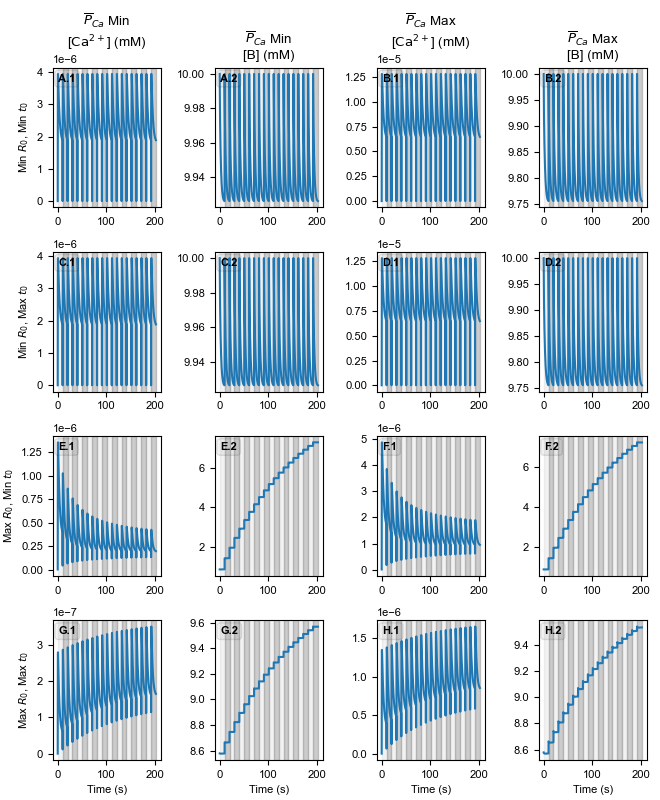

In [18]:
image_path = "supporting/figure7_fca.png"
Image(filename=image_path)

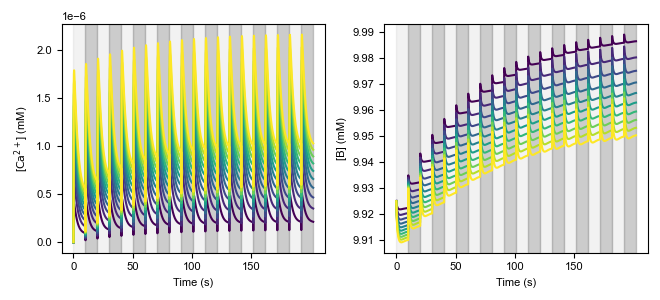

In [19]:
image_path = "supporting/figure8_fca.png"
Image(filename=image_path)

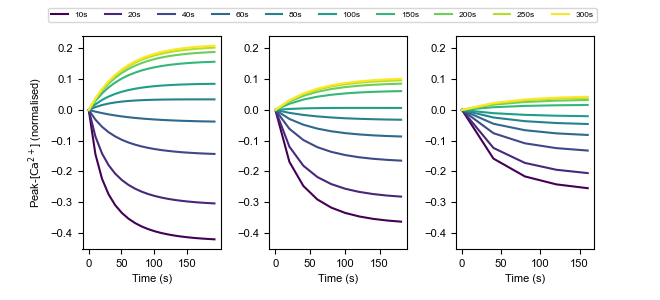

In [20]:
image_path = "supporting/figure9_fca.png"
Image(filename=image_path)

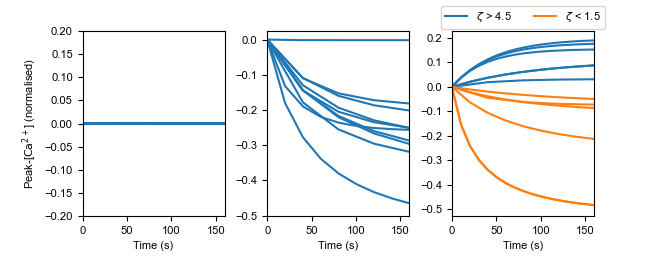

In [21]:
image_path = "supporting/figure10_fca.png"
Image(filename=image_path)